<a href="https://colab.research.google.com/github/Anirudh-Pranesh/LSTM_stock_prediction/blob/main/upd_LSTM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get desired dataset at : https://finance.yahoo.com/

Dataset used at the time of programming : https://finance.yahoo.com/quote/MSFT/history?period1=511056000&period2=1699660800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true (time period set to max)


---



In [ ]:
##### DATA PRE-PROCESSING #####
#Libraries
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy as np

df=pd.read_csv('MSFT.csv') # reading CSV file
df=df[['Date','Close']]

def str_to_dat(s): # function to change the date(of type string), to type datetime64[ns], so that we can work with the date values
  split=s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date']=df['Date'].apply(str_to_dat) # applies the function to all the dates in the CSV file

df.index=df.pop('Date') # changes the index values in CSV file (0,1,2,3,.....) to the dates instead. we dont need the index values, but rather we need them as the dates

# Ththe function below, is a function that changes the whole CSV file to a format ,as shown below the last graph. In this, we can see that there is a particular date, and 4 parameters target-3,
# target-2, target-1 and target. Target is the closing value of the stock ON THAT specified date, where as target-3 is the closing value of the stock 3 days before the given date, target-2
# is the closing value of the stock 2 days before the given date, and so on. Using the closing value of the stock 3 days prior to a given date, we can use AI (LSTM model) to predict the
# closing value of the stock on that particular day.

# We are naming this format of the CSV file as windowed_df

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_dat(first_date_str)
  last_date  = str_to_dat(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df,'2021-03-25','2023-11-10', n=3) # date must be changed depending on the dataset given

# Above, we are restricting windowed_df between the dates 2021-03-25 and 2023-11-10, because in graph-5, we can see that up until 2016, the values had been increasing quite steadily, after which it
# rapidly increased. If we were to train on the data between this period, our model would be extremely off, as it cannot predict the increase in stock value. This is because it has only been trained
# on the data where the value is steadily increasing. So it would not be able to predict the increase in the value. So, we train the model where the value is increasing, so it knows the current and
# recent trend, and thus it is able to predict the value in the future

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np=windowed_dataframe.to_numpy()
  dates= df_as_np[:, 0]
  mid_matrix=df_as_np[:, 1:-1]
  X=mid_matrix.reshape((len(dates), mid_matrix.shape[1],1))
  Y=df_as_np[:, -1]
  return dates, X.astype(np.float32) , Y.astype(np.float32)
dates, X, y = windowed_df_to_date_X_y(windowed_df)


# SEE GRAPH 1 TO SEE DATA SPLIT OF windowed_df

q_80 = int(len(dates) * .8) # q_80 has values of 80% of windowed_df
q_90 = int(len(dates) * .9) # q_90 has values of 90% of windowed_df
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80] # Training data has been given 80% of windowed_df(see the data below graph 5)
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90] # validation data has been given 10% of windowed_df
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:] # testing data has been given remaining 10% of windowed_df

##### MODEL SETUP ######

model=Sequential([layers.Input((3,1)), layers.LSTM(64), layers.Dense(32, activation='relu'), layers.Dense(32, activation='relu'), layers.Dense(1)])
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
17/17 [==============================] - 3s 41ms/step - loss: 76521.1719 - mean_absolute_error: 275.0684 - val_loss: 109127.7812 - val_mean_absolute_error: 330.1172
Epoch 2/100
17/17 [==============================] - 0s 8ms/step - loss: 76024.6719 - mean_absolute_error: 274.1644 - val_loss: 108314.5000 - val_mean_absolute_error: 328.8831
Epoch 3/100
17/17 [==============================] - 0s 8ms/step - loss: 75113.5312 - mean_absolute_error: 272.4962 - val_loss: 106859.3438 - val_mean_absolute_error: 326.6632
Epoch 4/100
17/17 [==============================] - 0s 9ms/step - loss: 73451.9141 - mean_absolute_error: 269.4366 - val_loss: 104139.5703 - val_mean_absolute_error: 322.4733
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 70610.9141 - mean_absolute_error: 264.1153 - val_loss: 99713.7266 - val_mean_absolute_error: 315.5362
Epoch 6/100
17/17 [==============================] - 0s 7ms/step - loss: 65959.4297 - mean_absolute_error: 255.1243 - va

# Graph 1

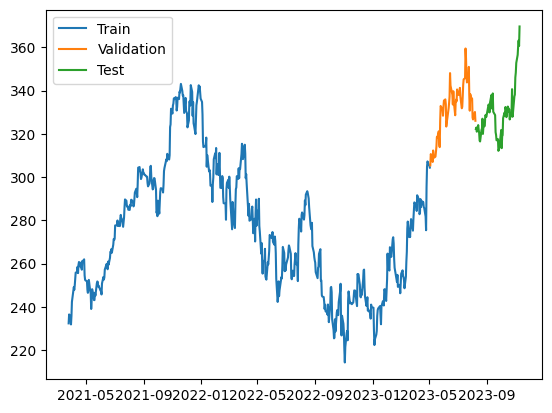

In [ ]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])

# **RESULTS : After training**

---



# Graph 2

Training results

17/17 [==============================] - 0s 2ms/step


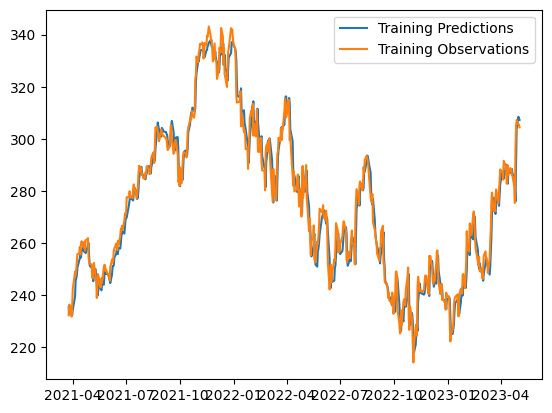

In [ ]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])


We can see that the predictions (blue) are extremely close the the real data (orange)

# Graph 3

Validation results

3/3 [==============================] - 0s 4ms/step


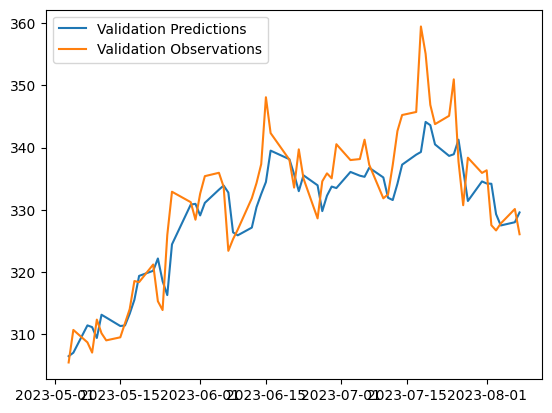

In [ ]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

Although the graphs look completely dissimilar, the graph is actually zoomed in. In reality the values are very close to each other and is also accurate

# Graph 4

Testing results

3/3 [==============================] - 0s 4ms/step


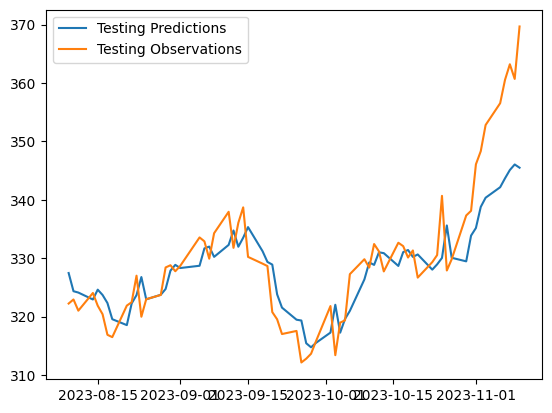

In [ ]:
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

similarly, the graphs look completely dissimilar, but the graph is actually zoomed in. In reality the values are very close to each other and is also accurate. We can only notice a slight deviation in the end at around 2023-11-01

# Graph 5

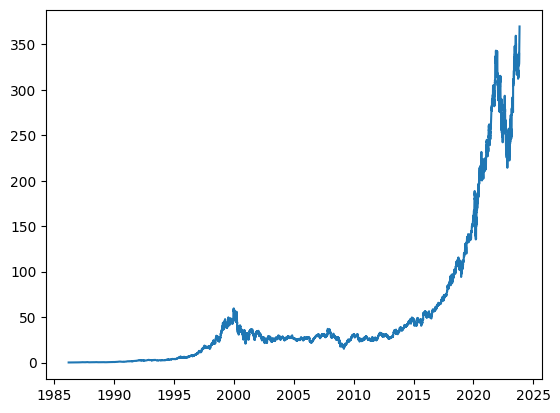

In [ ]:
plt.plot(df.index, df['Close'])

# windowed_df

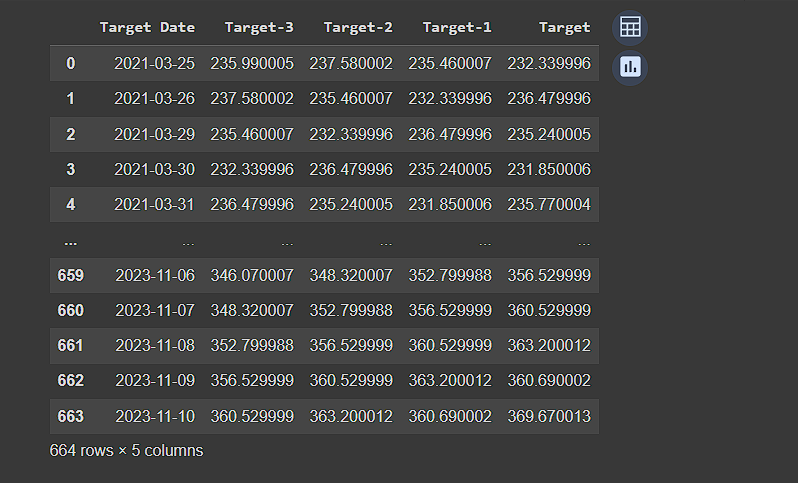

# **Conclusion**

The LSTM model is quite bad at extrapolating data. This is why it is not able to predict the stock values after 2015 if we train it with data between 1985-2015. The results are not shown when it is trained with 1985-2015 data, but it is extremely innacurate and completely off. Thus, it has been trained on the data that represents the recent trend, and it is good at giving an accurate predicted closing stock value when you are trying to predict what the value might be in the next few days.

So, the LSTM model can be used to predict on a short term basis. But when we are looking at it from a long term point of view, the model is not good at prediciting the value, and it is also extremely hard to predict stock values on a long term basis